# Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SparseCategoricalAccuracy, Precision, Recall
from tensorflow.keras.models import load_model
import seaborn as sns
import math
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

2024-05-04 15:47:12.920452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data load

In [2]:
# Path to the folder containing the images
folder_path = "./leedsbutterfly/images"

# Read all filenames in the folder
filenames = os.listdir(folder_path)

# Extract categories from the filenames
categories = {}
for filename in filenames:
    imagename, _ = os.path.splitext(filename)
    if imagename[1:3].isdigit():  # Check if the characters represent a valid integer
        category = int(imagename[1:3])  # Extract the category
        categories[filename] = category

# Load images and preprocess
image_size = (128, 128)  # Resize images to 128x128
images = []
original_labels = []
for filename in categories.keys():  # Iterate through valid filenames
    image_path = os.path.join(folder_path, filename)
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    images.append(img_array)
    
    # Set original_labels based on categories
    original_labels.append(categories[filename])

In [3]:
print(f"There are total {len(images)} images in this dataset.")

There are total 832 images in this dataset.


# Data Augemntation

This data is relatively small, so in order to deliver better results data augmentation is necessary. 

In [58]:
# Funktion zum Plotten von Bildern
def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

In [59]:
datagen = ImageDataGenerator(
    rotation_range=15,  # rotate images randomly up to 20 degrees
    width_shift_range=0.1,  # shift images horizontally up to 20% of the width
    height_shift_range=0.1,  # shift images vertically up to 20% of the height
    shear_range=0.1,  # shear transformation range
    zoom_range=0.1,  # zoom images up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # how to fill in newly created pixels
)

augmented_images = []
augmented_labels = []
for img_array, label in zip(images, original_labels):  # Loop over original images and their labels
    # Reshape the image array to (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Generate augmented images
    augmented_imgs_gen = datagen.flow(img_array, batch_size=1)
    for _ in range(4):  # Generate 3 augmented images per original image
        augmented_img = next(augmented_imgs_gen)[0].astype(np.uint16)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)  # Use the same label for the augmented image as for the original image

# Zusammenführen der originalen und augmentierten Bilder
all_images = images + augmented_images

# Zusammenführen der originalen und augmentierten Labels
all_labels = original_labels + augmented_labels

# Konvertiere die Bilder in ein NumPy-Array
all_images_array = np.array(all_images)

# Normalisierung durch Skalierung der Pixelwerte
all_images = all_images_array.astype('float32') / 255.0

# normalize 

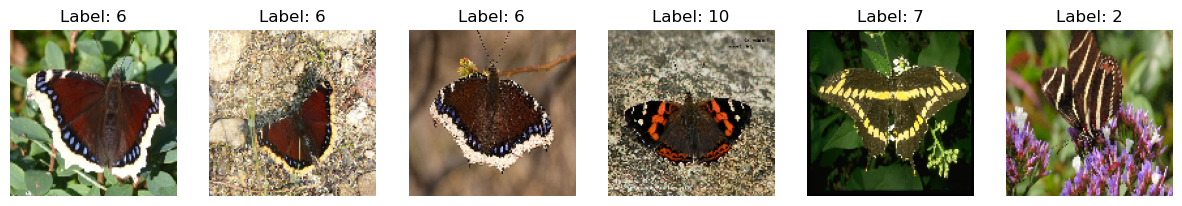

In [60]:
# Plot some images using the function
plot_images(all_images, all_labels, num_images=6)

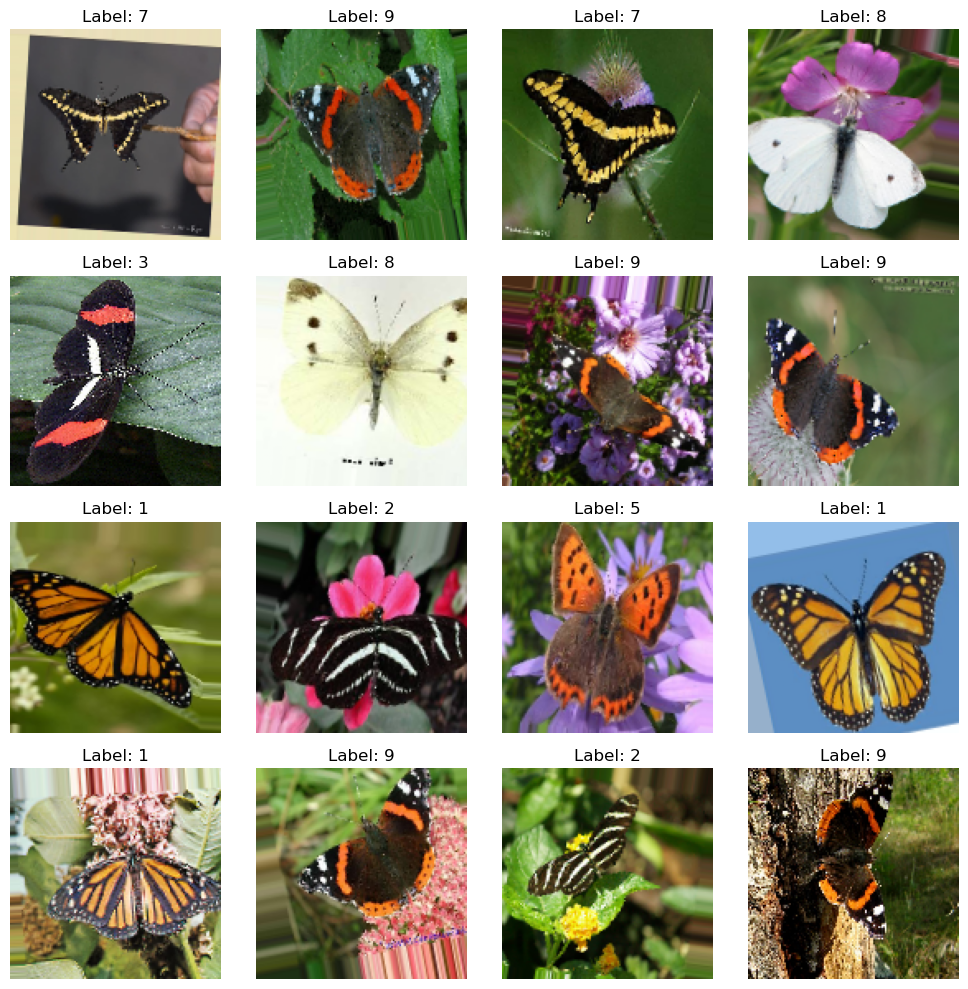

In [61]:
def plot_random_images(images, labels, num_images=25):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    indexes = random.sample(range(len(images)), num_images)
    
    for i, ax in enumerate(axes.flat):
        idx = indexes[i]
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_random_images(all_images, all_labels, num_images=25)

# Splitting sets

In [62]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
# Split the dataset into sets with only original images and sets with mixed pictures

# Original images only
train_orig_images, val_orig_images, train_orig_labels, val_orig_labels = train_test_split(
    images, original_labels, test_size=0.4, random_state=random_seed)

val_orig_images, test_orig_images, val_orig_labels, test_orig_labels = train_test_split(
    val_orig_images, val_orig_labels, test_size=0.5, random_state=random_seed)

# Mixed pictures (original + augmented)
train_mixed_images, val_mixed_images, train_mixed_labels, val_mixed_labels = train_test_split(
    all_images, all_labels, test_size=0.4, random_state=random_seed)

val_mixed_images, test_mixed_images, val_mixed_labels, test_mixed_labels = train_test_split(
    val_mixed_images, val_mixed_labels, test_size=0.5, random_state=random_seed)

# Print the sizes of the datasets for both types of sets
print("Original Images:")
print(f"Training set: {len(train_orig_images)} images")
print(f"Validation set: {len(val_orig_images)} images")
print(f"Test set: {len(test_orig_images)} images")

print("\nMixed Images (Original + Augmented):")
print(f"Training set: {len(train_mixed_images)} images")
print(f"Validation set: {len(val_mixed_images)} images")
print(f"Test set: {len(test_mixed_images)} images")

Original Images:
Training set: 499 images
Validation set: 166 images
Test set: 167 images

Mixed Images (Original + Augmented):
Training set: 2496 images
Validation set: 832 images
Test set: 832 images


In [9]:
# Convert train_orig_labels and val_orig_labels to NumPy arrays
train_orig_labels = np.array(train_orig_labels)
val_orig_labels = np.array(val_orig_labels)
test_orig_labels = np.array(test_orig_labels)

train_mixed_labels = np.array(train_mixed_labels)
val_mixed_labels = np.array(val_mixed_labels)
test_mixed_labels = np.array(test_mixed_labels)

In [10]:
# Subtract 1 from each label to ensure they range from 0 to 9
train_orig_labels -= 1
val_orig_labels -= 1
test_orig_labels -= 1

train_mixed_labels -= 1
val_mixed_labels -= 1
test_mixed_labels -= 1


In [11]:
# Rescaling the images
def normalize_images(images):
    # Convert images to NumPy array if it's a list
    if isinstance(images, list):
        images = np.array(images)
    
    # Convert images to float32
    images = images.astype('float32')
    
    # Normalize images to the range [0, 1]
    images /= 255.0
    
    return images

# Normalize original images
train_orig_images_normalized = normalize_images(train_orig_images)
val_orig_images_normalized = normalize_images(val_orig_images)
test_orig_images_normalized = normalize_images(test_orig_images)

# Normalize mixed images
train_mixed_images_normalized = normalize_images(train_mixed_images)
val_mixed_images_normalized = normalize_images(val_mixed_images)
test_mixed_images_normalized = normalize_images(test_mixed_images)

# Model with original images

In [12]:
original_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Assuming 10 different classes
])

/opt/anaconda3/envs/adls_nn/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
# Compile the model
original_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [14]:
# View the structure of the model
original_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model

history = original_model.fit(train_orig_images_normalized, train_orig_labels,
                             epochs=10,
                             validation_data=(val_orig_images_normalized, val_orig_labels))  # Validation data

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.1328 - loss: 2.3477 - val_accuracy: 0.2530 - val_loss: 2.1909
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.2407 - loss: 2.0970 - val_accuracy: 0.3855 - val_loss: 1.8265
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.3715 - loss: 1.7384 - val_accuracy: 0.4518 - val_loss: 1.5969
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step - accuracy: 0.5041 - loss: 1.4537 - val_accuracy: 0.5181 - val_loss: 1.3905
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.5576 - loss: 1.1724 - val_accuracy: 0.6506 - val_loss: 1.1028
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.6736 - loss: 0.9452 - val_accuracy: 0.6265 - val_loss: 1.0087
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.7776 - loss: 0.6791 - val_accuracy: 0.6687 - val_loss: 0.9491
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.7831 - loss: 0.6415 - val_accuracy: 0.

In [ ]:
# Train the model
#history = original_model.fit(train_orig_images_normalized, train_orig_labels,
#                              epochs=10,
#                              validation_data=(val_orig_images_normalized, val_orig_labels))

In [16]:
history.history

{'accuracy': [0.1442885845899582,
  0.2404809594154358,
  0.4108216464519501,
  0.5370741486549377,
  0.5831663608551025,
  0.6993988156318665,
  0.7915831804275513,
  0.7955911755561829,
  0.8396793603897095,
  0.8817635178565979],
 'loss': [2.2994985580444336,
  2.0460546016693115,
  1.6960487365722656,
  1.3873084783554077,
  1.1613504886627197,
  0.8881900906562805,
  0.6542819738388062,
  0.5921599864959717,
  0.4502658247947693,
  0.33328530192375183],
 'val_accuracy': [0.2530120611190796,
  0.3855421543121338,
  0.4518072307109833,
  0.5180723071098328,
  0.650602400302887,
  0.6265060305595398,
  0.6686747074127197,
  0.5843373537063599,
  0.6566265225410461,
  0.7048192620277405],
 'val_loss': [2.1909239292144775,
  1.8265149593353271,
  1.5968786478042603,
  1.39047110080719,
  1.1028196811676025,
  1.0086702108383179,
  0.9490770101547241,
  1.2815934419631958,
  0.9918591380119324,
  0.9508126378059387]}

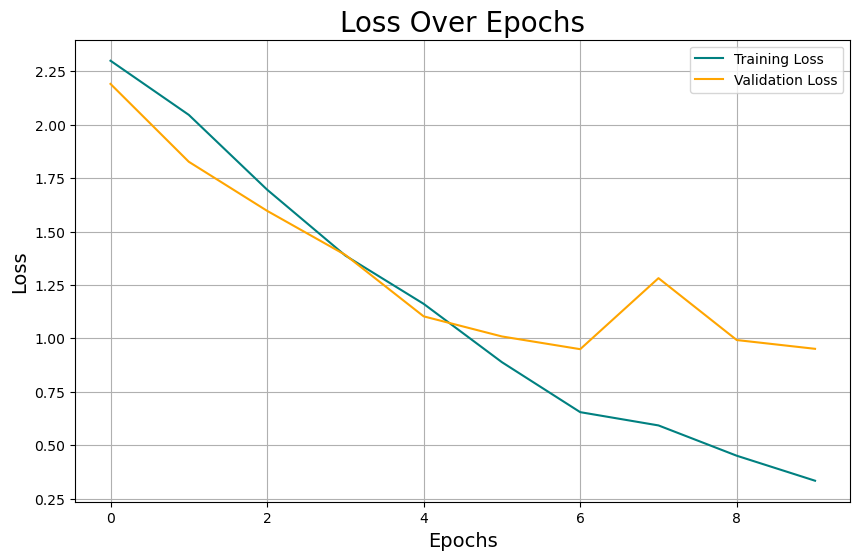

In [17]:
# Plot performance
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='teal', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


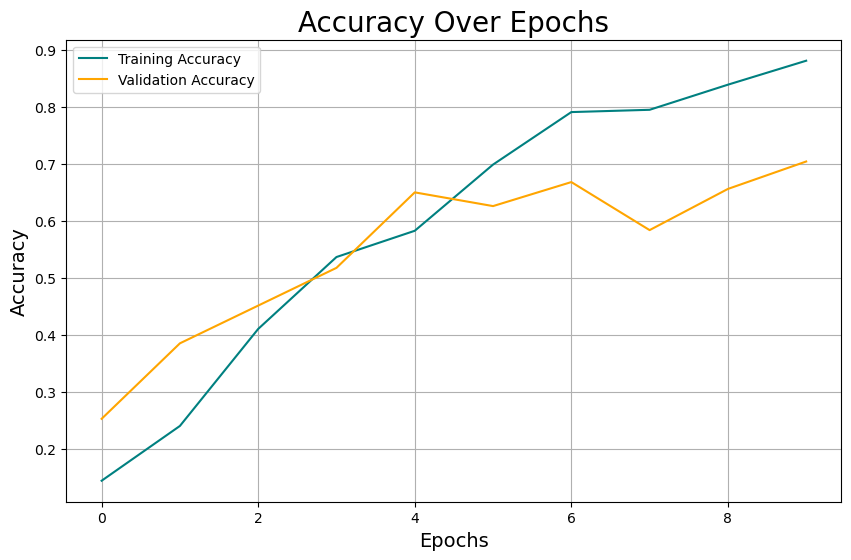

In [18]:
# Plot accuracy
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluate the model on the test set
test_loss, test_acc = original_model.evaluate(test_orig_images_normalized, test_orig_labels)

# Print the test accuracy
print(f"Test accuracy: {test_acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6560 - loss: 1.2542
Test accuracy: 0.688622772693634


# Model with augmented and original images

In [20]:
# Define the model
augmented_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='relu'),  # Dense layer with 128 neurons
    Dropout(0.5),  # Adding another dropout layer
    Dense(10, activation='softmax')  # Output layer with 10 classes
])

In [22]:
# Compile the model
augmented_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [23]:
# Print the model summary
augmented_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,550,218 (24.99 MB)

 Trainable params: 6,550,218 (24.99 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_augmented = augmented_model.fit(train_mixed_images_normalized, train_mixed_labels,
                              epochs=10,
                              validation_data=(val_mixed_images_normalized, val_mixed_labels))

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 0.1451 - loss: 2.3319 - val_accuracy: 0.4543 - val_loss: 1.8433
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 404ms/step - accuracy: 0.3450 - loss: 1.7773 - val_accuracy: 0.5805 - val_loss: 1.1956
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 360ms/step - accuracy: 0.5792 - loss: 1.1959 - val_accuracy: 0.7716 - val_loss: 0.7376
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 397ms/step - accuracy: 0.7075 - loss: 0.8484 - val_accuracy: 0.8413 - val_loss: 0.4971
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 356ms/step - accuracy: 0.7955 - loss: 0.5835 - val_accuracy: 0.8558 - val_loss: 0.4537
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 363ms/step - accuracy: 0.8682 - loss: 0.3836 - val_accuracy: 0.9002 - val_loss: 0.3461
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 373ms/step - accuracy: 0.9065 - loss: 0.2764 - val_accuracy: 0.8834 - val_loss: 0.3558
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 372ms/step - accuracy: 0.9366 - loss: 0.2137 - val_accu

In [25]:
history_augmented.history

{'accuracy': [0.18389423191547394,
  0.40504807233810425,
  0.6169871687889099,
  0.7319711446762085,
  0.8165063858032227,
  0.8677884340286255,
  0.9122596383094788,
  0.9346955418586731,
  0.9519230723381042,
  0.9543269276618958],
 'loss': [2.202613353729248,
  1.6111185550689697,
  1.0917388200759888,
  0.7675061821937561,
  0.5234495401382446,
  0.3918130397796631,
  0.2651795446872711,
  0.1983717530965805,
  0.18776977062225342,
  0.14628037810325623],
 'val_accuracy': [0.45432692766189575,
  0.5805288553237915,
  0.7716346383094788,
  0.8413461446762085,
  0.8557692170143127,
  0.9002403616905212,
  0.8834134340286255,
  0.9086538553237915,
  0.901442289352417,
  0.9146634340286255],
 'val_loss': [1.8433458805084229,
  1.195642113685608,
  0.737600564956665,
  0.49710023403167725,
  0.45370563864707947,
  0.3460948169231415,
  0.35583803057670593,
  0.31637680530548096,
  0.35937678813934326,
  0.2764585614204407]}

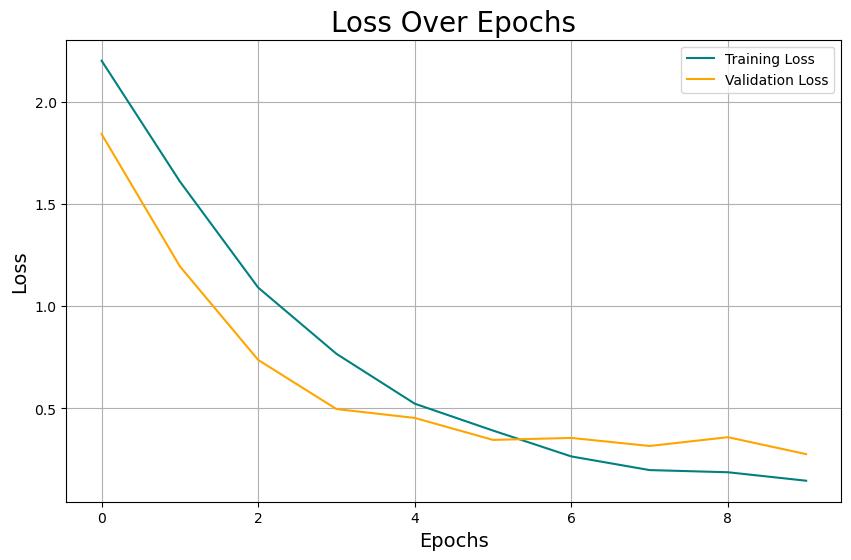

In [26]:
# Plot performance
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['loss'], color='teal', label='Training Loss')
plt.plot(history_augmented.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

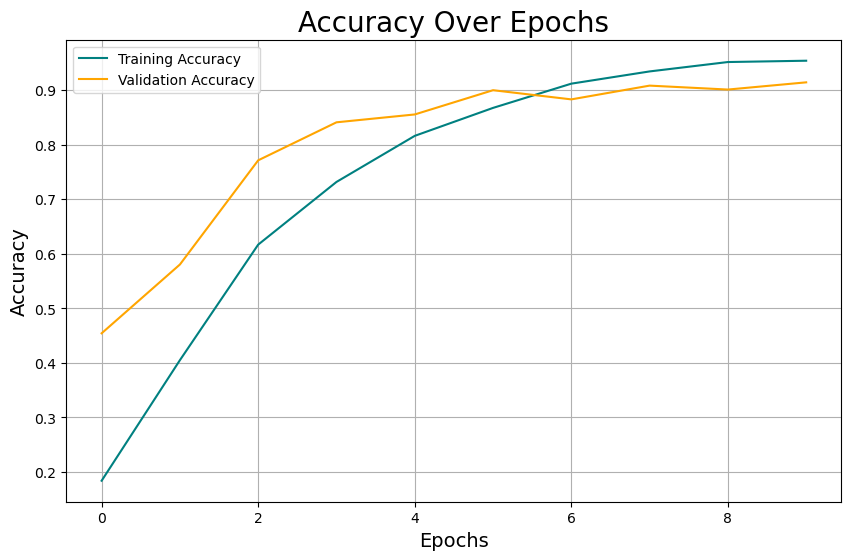

In [27]:
# Plot accuracy
fig = plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Evaluate the model on the test set
test_loss, test_acc = augmented_model.evaluate(test_mixed_images_normalized, test_mixed_labels)

# Print the test accuracy
print(f"Test accuracy: {test_acc}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9022 - loss: 0.2882
Test accuracy: 0.9086538553237915


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step


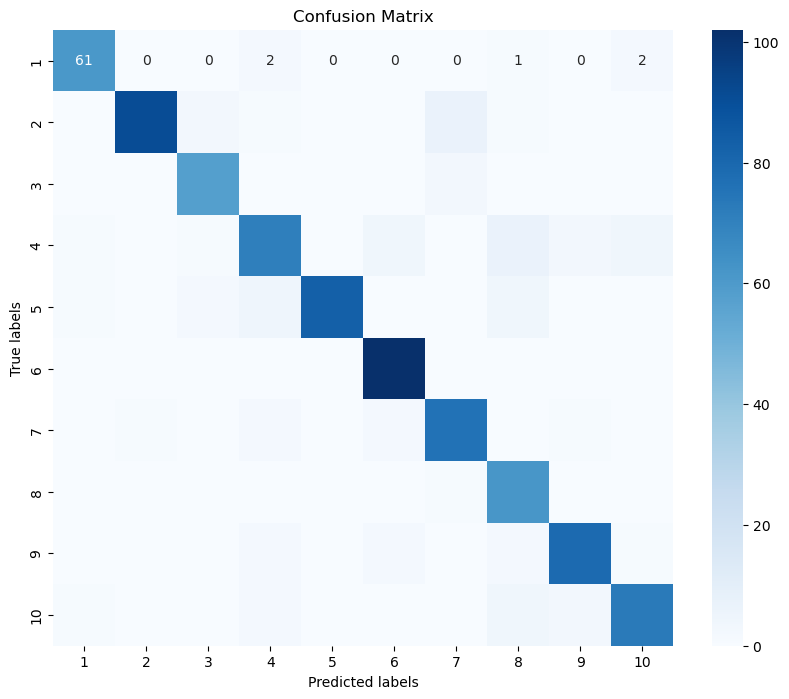

In [30]:
# Get the predicted probabilities for each class
predicted_probabilities = augmented_model.predict(test_mixed_images_normalized)

# Convert probabilities to class labels
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_mixed_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

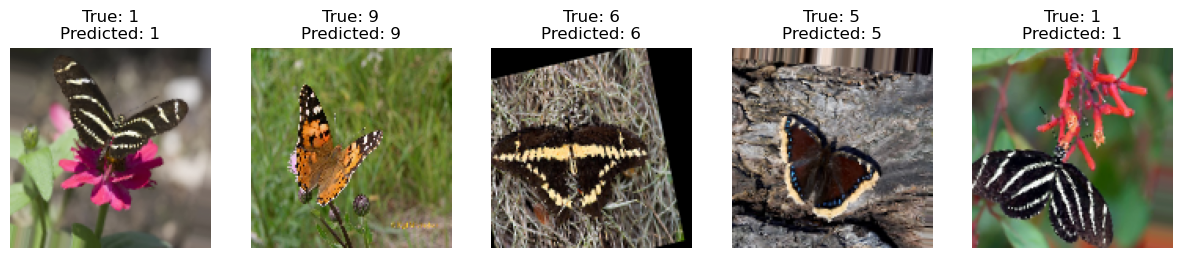

In [55]:
# Function to plot random images with their labels
def plot_random_images(images, labels_true, labels_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    num_images = min(num_images, len(images))  # Ensure num_images does not exceed the number of available images
    random_indices = random.sample(range(len(images)), num_images)
    
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx] / 255.0)  # Normalize image before plotting
        plt.title(f"True: {labels_true[idx]}\nPredicted: {labels_pred[idx]}")
        plt.axis('off')
    plt.show()

# Usage:
plot_random_images(test_mixed_images, test_mixed_labels, predictions, num_images=5)
